## Autoencoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5)

In [3]:
tf.__version__

'2.0.0-dev20190715'

In [4]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

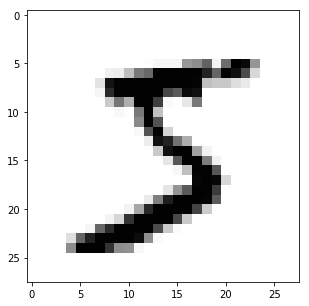

In [5]:
plt.figure(figsize=(5, 5))
image = np.reshape(X_train[0], [28, 28])
plt.imshow(image, cmap='Greys')
plt.show()

## simple autoencoder

In [6]:
def make_simple_encoder_model():
    input_layer = tf.keras.layers.Input(shape = (784))
    encode = tf.keras.layers.Dense(36, activation='relu')(input_layer)    
    output_layer = tf.keras.layers.Dense(784, activation='sigmoid')(encode)    
    
    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model,encoder

In [7]:
simple_model, simple_encoder = make_simple_encoder_model()

In [8]:
simple_model.summary()
simple_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 36)                28260     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 36)                28260     
Total params: 28,260
Trainable params: 2

In [9]:
simple_model.fit(X_train, X_train, epochs=50, batch_size=256,shuffle = True,verbose=True,validation_split = 0.2)

W0408 01:25:51.940625 140274159699712 deprecation.py:323] From /home/ubuntu/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0408 01:25:51.984851 140274159699712 deprecation.py:323] From /home/ubuntu/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 2s 33us/sample - loss: 0.2926 - mse: 0.0747 - val_loss: 0.1992 - val_mse: 0.0437
Epoch 2/50
48000/48000 [==============================] - 1s 24us/sample - loss: 0.1772 - mse: 0.0366 - val_loss: 0.1599 - val_mse: 0.0309
Epoch 3/50
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1502 - mse: 0.0279 - val_loss: 0.1412 - val_mse: 0.0248
Epoch 4/50
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1341 - mse: 0.0226 - val_loss: 0.1278 - val_mse: 0.0205
Epoch 5/50
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1226 - mse: 0.0190 - val_loss: 0.1182 - val_mse: 0.0174
Epoch 6/50
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1142 - mse: 0.0163 - val_loss: 0.1109 - val_mse: 0.0152
Epoch 7/50
48000/48000 [==============================] - 1s 24us/sample - loss: 0.1078 - mse: 0.0143 - val_loss: 0.

In [10]:
X_train_decode = simple_model(X_train)
X_train_pre = simple_encoder(X_train)

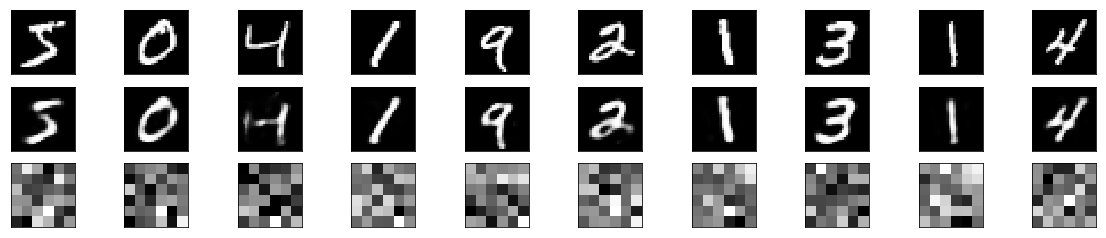

In [11]:
n = 10  # 몇 개의 숫자를 나타낼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(X_train[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_train_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoding 데이터
    ax = plt.subplot(3, n, i + 11 + n)
    plt.imshow(np.reshape(X_train_pre[i],[6, 6]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

첫번째 줄은 원본이미지이고, 두번째줄은 디코딩된 이미지이다. 꽤 많은 비트손실이 있는 것을 볼 수 있다.  
세번째 줄은 인코딩된 압축형태의 이미지이다.

## Adding a sparsity autoencoder

위의 autoencoder에서 표현(representation)은 은닉층의 크기(36)에만 제약을 받았다. 이러한 상황에서, 전형적으로 발생하는 일은 은닉층이 PCA(principal component analysis)의 근사값을 학습한다는 것이다. 표현을 더 간결하게 제한하는 방법은 숨겨진 표현의 활동에 sparsity를 부여하는 것이다. 이는 주어진 시간에 더 적은 유닛이 “실행”될 수 있도록 한다.  
Keras에서는 activity_regularizer를 Dense layer에 추가하여 수행할 수 있습니다.

In [12]:
def make_sparsity_encoder_model():
    input_layer = tf.keras.layers.Input(shape = (784))
    encode = tf.keras.layers.Dense(36, activation='relu',activity_regularizer =tf.keras.regularizers.l1(10e-5))(input_layer)    
    output_layer = tf.keras.layers.Dense(784, activation='sigmoid')(encode)    
    
    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model,encoder

In [13]:
sparsity_model, sparsity_encoder = make_sparsity_encoder_model()

In [14]:
sparsity_model.fit(X_train, X_train, epochs=100, batch_size=256,shuffle = True,verbose=True,validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 31us/sample - loss: 0.3016 - mse: 0.0745 - val_loss: 0.2089 - val_mse: 0.0430
Epoch 2/100
48000/48000 [==============================] - 1s 24us/sample - loss: 0.1867 - mse: 0.0361 - val_loss: 0.1689 - val_mse: 0.0305
Epoch 3/100
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1589 - mse: 0.0275 - val_loss: 0.1495 - val_mse: 0.0244
Epoch 4/100
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1435 - mse: 0.0226 - val_loss: 0.1376 - val_mse: 0.0206
Epoch 5/100
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1334 - mse: 0.0193 - val_loss: 0.1293 - val_mse: 0.0179
Epoch 6/100
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1260 - mse: 0.0169 - val_loss: 0.1232 - val_mse: 0.0159
Epoch 7/100
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1204 - mse: 0.0150 - val_l

In [15]:
X_train_decode = sparsity_model(X_train)
X_train_pre = sparsity_encoder(X_train)

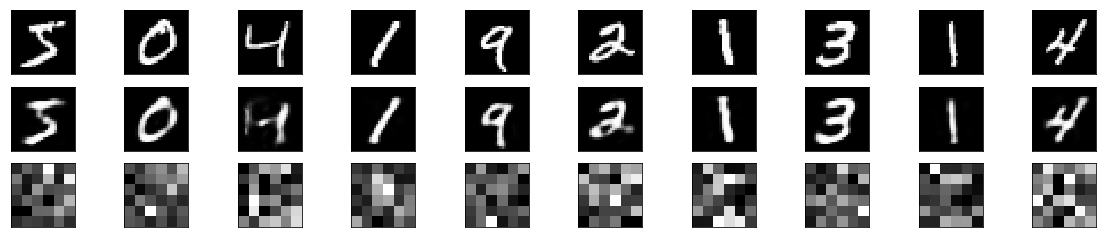

In [16]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(X_train[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_train_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoding 데이터
    ax = plt.subplot(3, n, i + 11 + n)
    plt.imshow(np.reshape(X_train_pre[i],[6, 6]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

이전 모델과 거의 비슷해 보인다. 유일한 차이는 학습 방법에 의한 인코딩된 표현의 sparsity이다. 이로 인해 좀 더 sparser한 인코딩된 표현을 얻을 수 있다.

## deep autoencoder

autoencoder는 모델 깊이의 제한은 없다. 좀 더 깊은 모델을 만들어 보자.

In [17]:
def make_deep_encoder_model():
    input_layer = tf.keras.layers.Input(shape = (784))
    layer1 = tf.keras.layers.Dense(400, activation='relu')(input_layer)
    encode = tf.keras.layers.Dense(100, activation='relu')(layer1)    
    layer1 = tf.keras.layers.Dense(400, activation='relu')(encode)
    output_layer = tf.keras.layers.Dense(784, activation='sigmoid')(layer1)    
    
    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model,encoder

In [18]:
deep_model, deep_encoder = make_deep_encoder_model()

In [19]:
deep_model.fit(X_train, X_train, epochs=100, batch_size=256,shuffle = True,verbose=True,validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 54us/sample - loss: 0.2002 - mse: 0.0450 - val_loss: 0.1181 - val_mse: 0.0179
Epoch 2/100
48000/48000 [==============================] - 2s 48us/sample - loss: 0.1039 - mse: 0.0135 - val_loss: 0.0952 - val_mse: 0.0107
Epoch 3/100
48000/48000 [==============================] - 2s 48us/sample - loss: 0.0905 - mse: 0.0092 - val_loss: 0.0878 - val_mse: 0.0083
Epoch 4/100
48000/48000 [==============================] - 2s 48us/sample - loss: 0.0847 - mse: 0.0074 - val_loss: 0.0837 - val_mse: 0.0071
Epoch 5/100
48000/48000 [==============================] - 2s 47us/sample - loss: 0.0811 - mse: 0.0063 - val_loss: 0.0804 - val_mse: 0.0060
Epoch 6/100
48000/48000 [==============================] - 2s 47us/sample - loss: 0.0785 - mse: 0.0055 - val_loss: 0.0784 - val_mse: 0.0054
Epoch 7/100
48000/48000 [==============================] - 2s 48us/sample - loss: 0.0768 - mse: 0.0050 - val_l

In [20]:
X_train_decode = deep_model(X_train)
X_train_pre = deep_encoder(X_train)

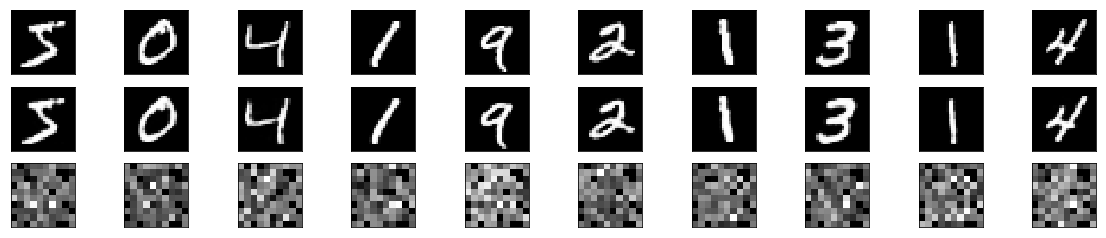

In [21]:
n = 10  # 몇 개의 숫자를 나타낼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(X_train[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_train_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoding 데이터
    ax = plt.subplot(3, n, i + 11 + n)
    plt.imshow(np.reshape(X_train_pre[i],[10, 10]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

위의 모델들 보다 약간은 나아보이는 형태이다. loss값 또한 더 낮아짐을 볼 수 있다.

## Convolutional autoencoder

예제에서 사용되는 데이터는 이미지이기 때문에 CNN을 이용하여 autoencoder를 구성하는 것이 가능하다. 이미지에 적용되는 autoencoder는 항상 convolutional autoencoder이다. 왜냐하면 성능이 더 좋기 때문.

In [22]:
def make_conv_encoder_model():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
    layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    layer1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(layer1)
    layer1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(layer1)
    layer1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(layer1)
    layer1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(layer1)
    encode = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(layer1)
    
    layer1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encode)
    layer1 = tf.keras.layers.UpSampling2D((2, 2))(layer1)
    layer1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(layer1)
    layer1 = tf.keras.layers.UpSampling2D((2, 2))(layer1)
    layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(layer1)
    layer1 = tf.keras.layers.UpSampling2D((2, 2))(layer1)
    output_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer1)

    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model,encoder

In [23]:
conv_model, conv_encoder = make_conv_encoder_model()

In [24]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [25]:
conv_model.fit(x_train, x_train, epochs=50, batch_size=256,shuffle = True,verbose=True,validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 36s 746us/sample - loss: 0.2946 - mse: 0.0764 - val_loss: 0.1879 - val_mse: 0.0436
Epoch 2/50
48000/48000 [==============================] - 35s 734us/sample - loss: 0.1686 - mse: 0.0368 - val_loss: 0.1571 - val_mse: 0.0326
Epoch 3/50
48000/48000 [==============================] - 36s 740us/sample - loss: 0.1473 - mse: 0.0291 - val_loss: 0.1417 - val_mse: 0.0269
Epoch 4/50
48000/48000 [==============================] - 36s 745us/sample - loss: 0.1363 - mse: 0.0251 - val_loss: 0.1330 - val_mse: 0.0239
Epoch 5/50
48000/48000 [==============================] - 36s 747us/sample - loss: 0.1296 - mse: 0.0228 - val_loss: 0.1277 - val_mse: 0.0221
Epoch 6/50
48000/48000 [==============================] - 35s 738us/sample - loss: 0.1253 - mse: 0.0213 - val_loss: 0.1241 - val_mse: 0.0208
Epoch 7/50
48000/48000 [==============================] - 35s 733us/sample - loss: 0.1219 - mse: 0.0201 

In [26]:
X_test_decode = conv_model(x_test)
X_test_pre = conv_encoder(x_test)

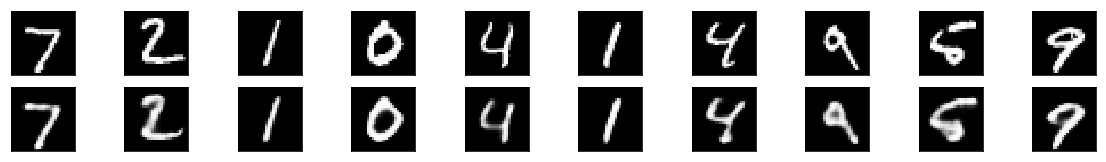

In [27]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(x_test[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_test_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

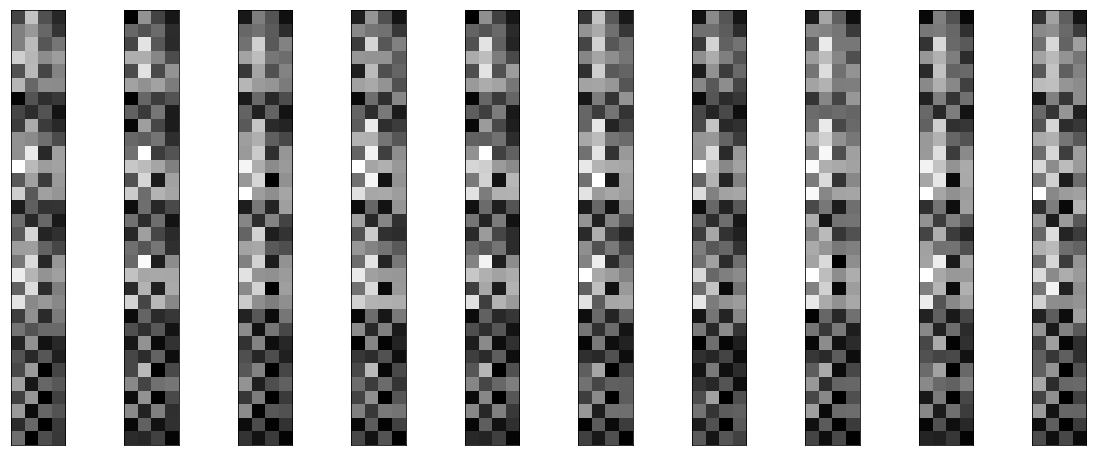

In [28]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.reshape(X_test_pre[i],[32, 4]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN으로도 인코딩된 표현으로도 볼 수 있다.

## denoising autoencoder

이제 우리의 convoultional autoencoder를 이미지 denoising 문제에 적용보자. 방법으론 노이지(noisy)한 숫자 이미지를 클린(clean)한 숫자 이미지로 매핑하는 autoencoder를 훈련시키면 된다.

In [29]:
noise_factor = 0.3
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

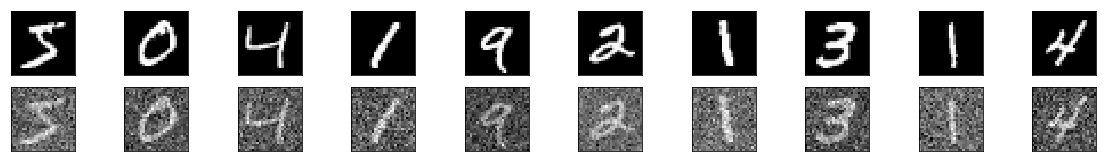

In [30]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(X_train[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_train_noisy[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

원본이미지에 노이즈를 주어 두번째 줄과 같은 이미지를 만들었다.

In [31]:
def make_denoise_encoder_model():
    input_layer = tf.keras.layers.Input(shape = (784))
    layer1 = tf.keras.layers.Dense(400, activation='relu')(input_layer)
    encode = tf.keras.layers.Dense(36, activation='relu')(layer1)    
    layer1 = tf.keras.layers.Dense(400, activation='relu')(encode)
    output_layer = tf.keras.layers.Dense(784, activation='sigmoid')(layer1)    
    
    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model,encoder

In [32]:
denoise_model, denoise_encoder = make_denoise_encoder_model()

In [33]:
denoise_model.fit(X_train_noisy, X_train, epochs=50, batch_size=256,shuffle = True,verbose=False,validation_split = 0.2)

In [34]:
X_train_decode = denoise_model(X_train_noisy)
X_train_pre = denoise_encoder(X_train_noisy)

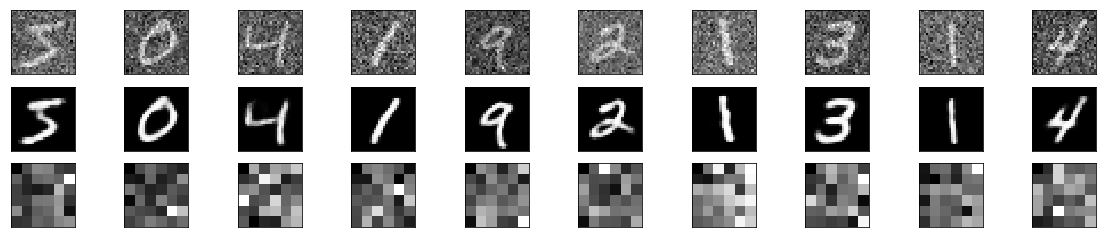

In [35]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(X_train_noisy[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(X_train_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoding 데이터
    ax = plt.subplot(3, n, i + 11 + n)
    plt.imshow(np.reshape(X_train_pre[i],[6, 6]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

노이즈 이미지를 보면 어느정도 숫자가 보이지만, 알아보기 힘든 경우도 있다. 두번째줄은 재구성한 이미지이다. 이처럼 노이즈가 포함된 이미지를 원본 숫자로 복원할 수 있다. 재구성된 이미지의 질을 더욱더 향상시키려면 CNN에서 많은 필터를 사용하면 된다.

## denoising autoencoder Conv2D

In [36]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

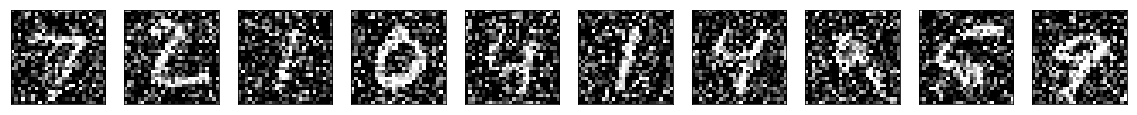

In [37]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
def make_encoder_model():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
    layer1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    layer1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(layer1)
    layer1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(layer1)
    encode = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(layer1)
    layer1 = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu', padding='same')(encode)
    layer1 = tf.keras.layers.UpSampling2D((2, 2))(layer1)
    layer1 = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu', padding='same')(layer1)
    layer1 = tf.keras.layers.UpSampling2D((2, 2))(layer1)
    output_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer1)

    model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adadelta')    
    
    encoder = tf.keras.Model(inputs=input_layer,outputs=encode)

    return model,encoder

In [47]:
model,encoder = make_encoder_model()

In [48]:
model.fit(x_train_noisy, x_train,epochs=100,batch_size=256,shuffle=True,validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.6968 - val_loss: 0.6937
Epoch 2/100
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.6906 - val_loss: 0.6876
Epoch 3/100
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.6844 - val_loss: 0.6811
Epoch 4/100
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.6767 - val_loss: 0.6715
Epoch 5/100
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.6631 - val_loss: 0.6536
Epoch 6/100
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.6393 - val_loss: 0.6232
Epoch 7/100
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.6003 - val_loss: 0.5766
Epoch 8/100
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.5503 - val_loss: 0.5305
Epoch 9/100
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.51

In [49]:
x_test_decode = model(x_test)
x_test_pre = encoder(x_test)

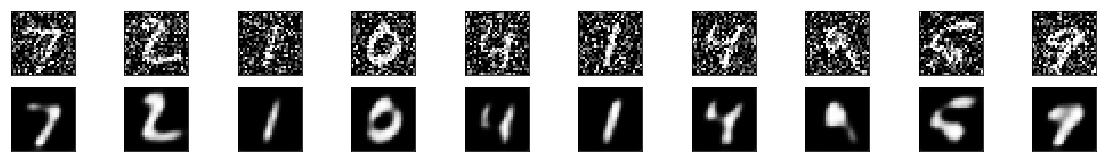

In [50]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.reshape(x_test_noisy[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.reshape(x_test_decode[i],[28, 28]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational autoencoder(VAE)

이는 학습된 인코딩 표현에 대한 제약 조건이 추가된 autoencoder 이다.. 더 정확히 말하자면, 입력 데이터에 대한 latent variable model 을 학습하는 autoencoder라고 할 수 있다. 따라서, 신경망에게 임의의 함수를 학습시키는 대신, 데이터를 모델링하는 확률 분포의 매개 변수를 학습시킨다. 만약, 이 분포에서 점(points)를 샘플링하면, 새로운 입력 데이터의 샘플 또한 생성할 수 있다.  
VAE는 “생성 모델” 이라 불린다.  
자세한 예제는 다음 글에서 기술한다.

### Conclusion

이번 글에서는 autoencoder의 기본적인 방법을 소개했다. 다음 글에서 VAE와 autoencoder의 응용에 대해서 알아보겠다.